# Import

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline

import os

import xgboost as xgb 
from xgboost import plot_importance , XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from tqdm import notebook
import time

from tqdm import tqdm, notebook
import time

# Read Data

In [2]:
train_original = pd.read_csv('./open data/train.csv')
test_original = pd.read_csv('./open data/test_x.csv')
train = train_original.copy()
test = test_original.copy()

In [3]:
# fill NA
def fill_married(data):
    pdata = data.copy()
    pdata.loc[ (pdata.married==0)&(pdata.age_group=='10s'),'married' ] = 1
    pdata.loc[ (pdata.married==0)&(pdata.age_group=='20s'),'married' ] = 1
    pdata.loc[pdata.married==0,'married'] = 2
    
    return pdata

def fill_education(data):
    pdata = data.copy()
    pdata.loc[(pdata.education==0)&(pdata.age_group=='10s'),'education'] = 2
    pdata.loc[pdata.education==0,'education'] = 3

    return pdata

def fill_engnat(data):
    pdata = data.copy()
    pdata.loc[pdata.engnat==0,'engnat'] = 1
    
    return pdata

def fill_hand(data):
    pdata = data.copy()
    pdata.loc[pdata.hand==0,'hand'] = 1
    
    return pdata
# feature engineering
def Mach_score(data):
    pdata = data.copy()
    Answers = []
    for i in range(20):
        Answers.append('Q'+chr(97+i)+'A')
    reverse_col = ['QeA','QfA','QkA','QqA','QrA','QaA','QdA','QgA','QiA','QnA']
    for col in reverse_col:
        pdata[col] = -pdata[col]
    pdata['Mach_score'] = pdata[Answers].sum(axis=1)
    
    return pdata

def w_score(data):
    pdata = data.copy()
    wr = []
    wf = []
    for i in range(1,14):
        wr.append(f'wr_{i:02d}')
    for i in range(1,4):
        wf.append(f'wf_{i:02d}')
    
    pdata['wr'] = pdata[wr].sum(axis=1)
    pdata['wf'] = pdata[wf].sum(axis=1)
    
    return pdata

def TIPI(data):
    pdata = data.copy()
    pdata['tp_score_1'] = pdata['tp01'] - pdata['tp06']
    pdata['tp_score_2'] = pdata['tp07'] - pdata['tp02']
    pdata['tp_score_3'] = pdata['tp03'] - pdata['tp08']
    pdata['tp_score_4'] = pdata['tp09'] - pdata['tp04']
    pdata['tp_score_5'] = pdata['tp05'] - pdata['tp10']
    
    return pdata

# drop outlier
def drop_outlier(data, datatype):
    
    assert datatype == 'train' or datatype=='test', 'Wrong data type given'
    
    pdata = data.copy()
    if datatype=='train':
        
        out_arr = []
        out_arr.append( data[data.familysize>=16].index )
        out_arr.append( data[data.wr<=3].index )
        out_arr.append( data[data.wf>=2].index )

        out = []
        for outarr in out_arr:
            out = np.union1d(out, outarr)

        pdata = data.drop(out)
    
    return pdata
# feature banding
def age_band(data):
    pdata = data.copy()
    pdata['age_group'].replace(['10s','20s','30s','40s','50s','60s','+70s'],[1,2,3,4,5,5,5],inplace=True)
    
    return pdata

def E_band(data, num_band):
    pdata = data.copy()
    for i in range(20):
        col = 'Q'+chr(i+97)+'E'
        pdata[col] = pd.qcut(pdata[col],num_band)
        unique = pdata[col].unique()
        pdata[col].replace(unique,range(num_band),inplace=True)
        
    return pdata

def family_band(data):
    pdata = data.copy()
    pdata.loc[pdata.familysize >= 6,'familysize'] = 6
    
    return pdata
# categorical value to numerical value
def cat_gender(data):
    feature = 'gender'
    pdata = data.copy()
    pdata[feature].replace(['Male','Female'],[0,1],inplace=True)
    
    return pdata

def cat_race(data):
    feature = 'race'
    pdata = data.copy()
    unique = ['White', 'Asian', 'Other', 'Black', 'Native American', 'Arab', 'Indigenous Australian']
    pdata[feature].replace(unique,[0,1,2,3,4,5,6],inplace=True)
    
    return pdata

def cat_religion(data):
    feature = 'religion'
    pdata = data.copy()
    unique = ['Other', 'Hindu', 'Agnostic', 'Atheist', 'Christian_Other',
       'Christian_Catholic', 'Muslim', 'Buddhist', 'Christian_Protestant',
       'Jewish', 'Christian_Mormon', 'Sikh']
    pdata[feature].replace(unique,[11,10,0,1,2,3,4,5,6,7,8,9],inplace=True)
    
    return pdata

def cat_num(data):
    pdata = data.copy()
    pdata = cat_gender(pdata)
    pdata = cat_race(pdata)
    pdata = cat_religion(pdata)
    
    return pdata
# drop feature
def drop_feature(data, feature_arr):
    arr = feature_arr + ['index'] 
    
    """for i in range(20):
        arr.append('Q'+chr(i+97)+'A')
    for i in range(20):
        arr.append('Q'+chr(i+97)+'E')
    for i in range(1,14):
        arr.append(f'wr_{i:02d}')
    for i in range(1,4):
        arr.append(f'wf_{i:02d}')
    for i in range(1,11):
        arr.append(f'tp{i:02d}')"""
    

    pdata = data.drop(arr,axis=1)
    
    return pdata


In [4]:
def preprocess(data, datatype, feature_arr=[]):
    
    pdata = data.copy()
    # fill NA
    pdata = fill_married(pdata)
    pdata = fill_education(pdata)
    pdata = fill_engnat(pdata)
    pdata = fill_hand(pdata)
    # feature engineering
    pdata = Mach_score(pdata)
    pdata = w_score(pdata)
    pdata = TIPI(pdata)
    # drop outlier
    pdata = drop_outlier(pdata,datatype)
    # feature banding
    pdata = age_band(pdata)
    pdata = family_band(pdata)
    pdata = E_band(pdata,10)
    # categorical value to numerical value
    pdata = cat_num(pdata)
    # drop feature
    pdata = drop_feature(pdata, feature_arr)
    # unify type of data
    pdata = pdata.astype(np.int)
    
    return pdata

In [5]:
def submission(test_data, model_arr,file_name):
    score = np.zeros((test_data.shape[0],2))
    num_model = len(model_arr)
    for i in range(num_model):
        score += model_arr[i].predict_proba(test_data)
    pred = np.divide(score,num_model)[:,1]
    data = {'index':test['index'],'voted':pred}
    submission = DataFrame(data)
    submission.to_csv('./submission/'+file_name+'.csv',index=False)
    
    return pred

In [6]:
def train_auc(model_arr, data, label):
    score = np.zeros((data.shape[0],2))
    num_model = len(model_arr)
    for i in range(num_model):
        score += model_arr[i].predict_proba(data)
    pred = np.divide(score,num_model)[:,1]
    
    return roc_auc_score(label, pred)

# XGBoost

In [7]:
def xgb_pred_per(param, bad_arr):
    
    train_x = preprocess(train,'train',bad_arr)
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    test_x = preprocess(test,'test',bad_arr)

    model = XGBClassifier(**param)
    
    start_train = time.time()
    model.fit(train_x,train_y, verbose=False)
    print(f'Training : {time.time()-start_train:.2f}s')
    
    # print(f'{param["max_depth"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}', end=' ')
    
    train_xx = preprocess(train,'test',bad_arr)
    train_yy = train_xx['voted']
    train_xx = train_xx.drop(['voted'],axis=1)
    
    pred_auc = train_auc([model], train_xx, train_yy)
    print(f'{pred_auc:.6f}')
    
    file_name = f'xgb_{param["max_depth"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}_{pred_auc:.4f}'
    submission(test_x,[model],file_name)
    
    return model

In [22]:
opt = { 'max_depth' : 8,
        'n_estimators' : 200,
        'learning_rate' : 0.010,
         'min_child_weight' : 6,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8}
opt_gpu = { 'max_depth' : 8,
        'n_estimators' : 200,
        'learning_rate' : 0.010,
         'min_child_weight' : 6,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8,
        'tree_method' : 'gpu_hist'
       }

In [11]:
opt_arr_1 = ['QbA','QcA','QjA','QhA','QmA','QtA','QlA','QkA','QoA',
 'QsA','QrA', 'QeA',  'QnA','QgA', 'QdA'] + \
['QaE','QbE','QcE','QeE','QgE','QmE','QfE','QiE','QoE',
 'QlE','QrE','QpE','QnE','QtE','QsE','QkE'] + \
['tp01','tp04','tp05','tp09','tp10','tp02', 'tp08'] +\
['wf_01', 'wf_03'] + \
['wr_06','wr_09', 'wr_11','wr_07', 'wr_12','wr_13'] +\
['tp_score_4','hand']

opt_arr_2 = ['QjA','QaE', 'QbA', 'QeE', 'QfE', 'QhA', 'QiE', 'tp09', 'tp_score_4',
      'QbE', 'QtA', 'tp01', 'tp_score_2',
       'QmA', 'QmE', 'tp04',
       'QgE', 'QkA', 'QoE', 'QsA',
       'QlE', 'QoE', 'QrE', 'wf_03',
       'QoA', 'QlA', 'QsE', 'tp10',
       'QpE', 'tp08', 'wf_01',
       'QkE', 'QrA', 'wr_05', 'wr_09', 'wr_10', 'wr_11',
       'QgA', 'QtE', 'hand', 'tp06', 'QeA', 'wr_06', 'wr_12',
       'wr_03', 'wr_07', 'QdA', 'QdE', 'QnE', 'wr_13'
      ]

opt_arr_3 = ['QaE', 'QbA', 'QbE', 'QfE', 'QgE', 'QhA', 'QjA', 'QkA', 'QmA', 'QmE', 
             'QqA', 'QrA', 'QrE', 'QsA', 'QtA', 'tp04', 'tp09', 'wf_03', 'wr_13', 
             'tp_score_4', 'QdA', 'QiE', 'QlA', 'QlE', 'QoA', 'QpE', 'tp01', 
             'wr_06', 'QnE', 'QoE', 'QsE', 'hand', 'tp10', 'wf_01', 'wr_12', 
             'QeA', 'QeE', 'wr_11', 'QcA', 'tp02', 'wr_10']

In [10]:
test_gpu = { 'max_depth' : 12,
        'n_estimators' : 200,
        'learning_rate' : 0.010,
         'min_child_weight' : 6,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8,
        'tree_method' : 'gpu_hist'
       }

In [11]:
model2 = xgb_pred_per(test_gpu, [])

Training : 223.98s
0.903820


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

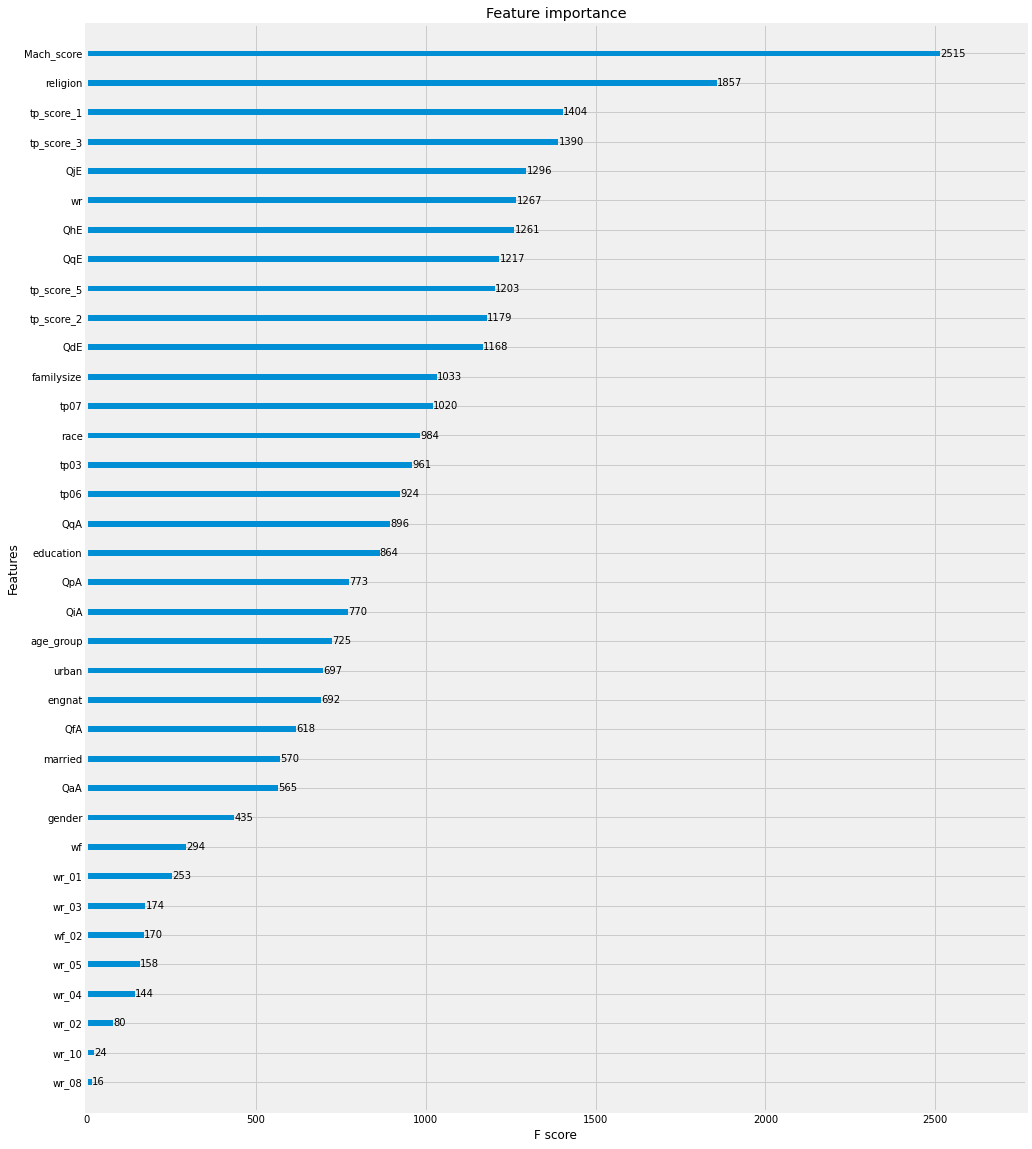

In [13]:
fig, ax = plt.subplots(figsize=(15,20))
plot_importance(model2, ax=ax)

# LightGBM

In [9]:
def lgbm_pred_per(param,bad_arr):

    train_x = preprocess(train,'train',bad_arr)
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    test_x = preprocess(test,'test',bad_arr)
    
    model = LGBMClassifier(**param)
    model.fit(train_x,train_y, verbose=False)


    print(f'{param["max_depth"]}_{param["num_leaves"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}_{param["feature_fraction"]:.2f}_{param["bagging_fraction"]:.2f}_{param["lambda_l1"]:.2f}_{param["lambda_l2"]:.2f} : ', end=' ')
    pred_auc = train_auc([model], train_x, train_y)
    print(f'{pred_auc:.4f}')
    file_name = f'lgbm_{param["max_depth"]}_{param["num_leaves"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}_{param["feature_fraction"]:.2f}_{param["bagging_fraction"]:.2f}_{param["lambda_l1"]:.2f}_{param["lambda_l2"]:.2f}_{pred_auc:.4f}'
    submission(test_x,[model],file_name)
    
    return model

In [10]:
lgbm_opt= { 'max_depth' : 5, 
            'num_leaves' : 359,
            'n_estimators' : 581,
            'learning_rate' : 0.05,
            'min_child_weight' : 37,
            'colsample_bytree' : 0.67,
            'feature_fraction' : 0.77,
            'bagging_fraction' : 0.91,
            'lambda_l1' : 0.41,
            'lambda_l2' : 0.09,
            'objective' : 'binary',
            'boosting_type' : 'dart'
            }

In [23]:
lgbm_arr = ['QaE', 'QbA', 'QeA', 'QfE', 'QgE', 'QhA', 'QjA', 'QmA', 'QmE', 'QnA', 'QoA', 'QoE', 'QpE', 'QtA', 'tp03', 'tp09', 'wf_02', 'wf_03', 'tp_score_2', 'tp_score_4', 'QkE', 'QlA', 'QsA', 'QsE', 'tp01', 'wr_13', 'QdA', 'QeE', 'QrE', 'hand']


In [12]:
model2 = lgbm_pred_per(lgbm_opt,opt_arr_2)

[LightGBM] [Warning] feature_fraction is set=0.77, colsample_bytree=0.67 will be ignored. Current value: feature_fraction=0.77
[LightGBM] [Warning] lambda_l1 is set=0.41, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] lambda_l2 is set=0.09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09
5_359_581_0.050_37_0.67_0.77_0.91_0.41_0.09 :  0.7930


# Ensemble

In [14]:
def train_models(types ,params, arr):
    
    assert len(params)==len(types), 'Num mismatch'
    
    model_list = []
    
    train_x = preprocess(train,'train',arr)
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    
    for i in range(len(types)):
        
        if types[i]=='xgb':
            model = XGBClassifier(**params[i])
            model.fit(train_x,train_y, verbose=False)
        elif types[i]=='lgbm':
            model = LGBMClassifier(**params[i])
            model.fit(train_x,train_y, verbose=False)
        else : 
            print('Wrong model type')
        
        model_list.append(model)
    
    return model_list

In [21]:
def ensemble(types,params,arr, r):
    
    model_arr = train_models(types,params,arr)
    num_model = len(model_arr)
    
    assert num_model==len(r), 'ratio mismatch'
    
    test_x = preprocess(test,'test',arr)
    score = np.zeros((test_x.shape[0],2))
    
    for i in range(num_model):
        score += model_arr[i].predict_proba(test_x)*r[i]

    data = {'index':test['index'],'voted':score[:,1]}
    submission = DataFrame(data)
    
    file_name = 'ensemble_opt_arr_1'
    for i in range(num_model):
        file_name = file_name + f'_{r[i]}'
        
    submission.to_csv('./submission/'+file_name+'.csv',index=False)

    return model_arr

In [83]:
xgb_1 = { 'max_depth' : 8,
        'n_estimators' : 200,
        'learning_rate' : 0.01,
         'min_child_weight' : 6,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8}

xgb_2 = { 'max_depth' : 8,
        'n_estimators' : 250,
        'learning_rate' : 0.01,
         'min_child_weight' : 1,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8}

lgbm_1 = { 'max_depth' : 5, 
            'num_leaves' : 359,
            'n_estimators' : 581,
            'learning_rate' : 0.05,
            'min_child_weight' : 37,
            'colsample_bytree' : 0.67,
            'feature_fraction' : 0.77,
            'bagging_fraction' : 0.91,
            'lambda_l1' : 0.41,
            'lambda_l2' : 0.09,
            'objective' : 'binary',
            'boosting_type' : 'dart'
            }

lgbm_2 = { 'max_depth' : 5, 
            'num_leaves' : 359,
            'n_estimators' : 581,
            'learning_rate' : 0.05,
            'min_child_weight' : 37,
            'colsample_bytree' : 0.67,
            'feature_fraction' : 0.77,
            'bagging_fraction' : 0.91,
            'lambda_l1' : 0.41,
            'lambda_l2' : 0.09,
            'objective' : 'binary',
            'boosting_type' : 'dart'
            }

In [18]:
lgbm_opt= { 'max_depth' : 5, 
            'num_leaves' : 359,
            'n_estimators' : 581,
            'learning_rate' : 0.05,
            'min_child_weight' : 37,
            'colsample_bytree' : 0.67,
            'feature_fraction' : 0.77,
            'bagging_fraction' : 0.91,
            'lambda_l1' : 0.41,
            'lambda_l2' : 0.09,
            'objective' : 'binary',
            'boosting_type' : 'dart'
            }

In [20]:
model_list = ensemble(['xgb','lgbm'], [opt,lgbm_opt], opt_arr_1, [0.78, 0.21])

[LightGBM] [Warning] feature_fraction is set=0.77, colsample_bytree=0.67 will be ignored. Current value: feature_fraction=0.77
[LightGBM] [Warning] lambda_l1 is set=0.41, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] lambda_l2 is set=0.09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09


In [23]:
lgbm_opt_arr = ['tp_score_2', 'QaE', 'QgE', 'QhA', 'QjA', 'QmA', 'QoA', 'QoE', 
                'QpE', 'QrE', 'tp09', 'wf_02', 'tp_score_4', 'QbA', 'QfE', 'QiA', 
                'QlE', 'QtA', 'tp04', 'QsA', 'tp01', 'wr_13', 'QmE', 'QsE', 'wf_03']

In [25]:
def train_models_(types ,params, arrs):
    
    assert len(params)==len(types), 'Num mismatch'
    
    model_list = []
    
    for i in range(len(types)):
        train_x = preprocess(train,'train',arrs[i])
        train_y = train_x['voted']
        train_x = train_x.drop(['voted'],axis=1)
        
        if types[i]=='xgb':
            model = XGBClassifier(**params[i])
            model.fit(train_x,train_y, verbose=False)
        elif types[i]=='lgbm':
            model = LGBMClassifier(**params[i])
            model.fit(train_x,train_y, verbose=False)
        else : 
            print('Wrong model type')
        
        model_list.append(model)
    
    return model_list

In [33]:
def ensemble_(types,params,arrs, r):
    
    model_arr = train_models_(types,params,arrs)
    num_model = len(model_arr)
    
    assert num_model==len(r), 'ratio mismatch'
    
    sc = np.zeros((train.shape[0],2))
    for i in range(num_model):
        tr_x = preprocess(train,'test',arrs[i])
        tr_y = tr_x['voted']
        tr_x = tr_x.drop(['voted'],axis=1)
        sc += model_arr[i].predict_proba(tr_x)*r[i]
    print(roc_auc_score(tr_y,sc[:,1]))

    score = np.zeros((test.shape[0],2))
    for i in range(num_model):
        test_x = preprocess(test,'test',arrs[i])
        score += model_arr[i].predict_proba(test_x)*r[i]

    data = {'index':test['index'],'voted':score[:,1]}
    submission = DataFrame(data)
    
    file_name = 'ensemble_opt_arr_1'
    for i in range(num_model):
        file_name = file_name + f'_{r[i]}'
        
    submission.to_csv('./submission/'+file_name+'.csv',index=False)

    return model_arr

In [35]:
model_list1 = ensemble_(['xgb','lgbm'], [opt,lgbm_opt], [opt_arr_3,lgbm_opt_arr], [0.76, 0.24])

[LightGBM] [Warning] feature_fraction is set=0.77, colsample_bytree=0.67 will be ignored. Current value: feature_fraction=0.77
[LightGBM] [Warning] lambda_l1 is set=0.41, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] lambda_l2 is set=0.09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09
0.809425071330867


In [36]:
model_list1 = ensemble_(['xgb','lgbm'], [opt,lgbm_opt], [opt_arr_1,lgbm_opt_arr], [0.62, 0.38])

[LightGBM] [Warning] feature_fraction is set=0.77, colsample_bytree=0.67 will be ignored. Current value: feature_fraction=0.77
[LightGBM] [Warning] lambda_l1 is set=0.41, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] lambda_l2 is set=0.09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09
0.8063089379077804
